# Transform 3D -> 2D

This notebook shows how to apply the determined transformations from the Slice2Volume Fiji macro to abritrary 3D image data (e.g., MRI, CT, Dose/LET arrays, Atlas) to any given histological plane. This requires:

* A copy of elastix installed on your computer. [Download link](https://elastix.lumc.nl/)
* A set of Slice2Volume results files (e.g., `S2V_LogFile.txt` and `SliceAssignmentOverview.txt`
* The transformation files for the histological section to be used as target image space. For instance, in order to project a slice of 3D image `X` into the space of histological section `0001_Scene_1...`, this requires the file `0001_Scene_1_trafo_inverse.txt`

In [1]:
import os
import subprocess
import glob
import shutil

import napari
from skimage import io, transform

import pandas as pd
import numpy as np

We first specify some of the input/output parameters.

* The `target_image` is the directory with images of one slice bundle over which the data will be overlaid.
* The `source_image` will be warped to be overlaid with the `target_image`, this should be a 3D image.
* `slice_assignnment_file`: The S2V repository contains a `SliceAssignment_Overview.txt` file (usually at `mouse/Histology/warped/results`) for each aanimal. Specify its location here.
* `log_file`: The S2V repository contains a `S2V_LogFile.txt` file (usually at `mouse/Histology/warped/results`) for each aanimal. Specify its location here.
* `trafo_dir`: The S2V repository cotains a `trafo` directory (usually at `mouse/Histology/warped/trafo`) for each mouse. Specify location here.
* `elastix_dir`: Path to the directory with elastix and transformix executables on your computer.
* `output_dir`: Directory were the output should be saved. Filename will be created automatically (e.g., 0001_Scene_1_LET.tif for the transformed LET image that refers to the slices 0001_Scene_1).

In [2]:
# Config
scale = np.array([0.1, 0.1, 0.1])  # microns
target_image = r'E:\Promotion\Projects\2020_Slice2Volume\Data\P2A_C3H_M3\Histology\Slices\0005_Scene_1'
source_image = r'E:\Promotion\Projects\2020_Slice2Volume\Data\P2A_C3H_M3\Simulation\LET.tif'

slice_assignment_file = r'E:\Promotion\Projects\2020_Slice2Volume\Data\P2A_C3H_M3\Histology\Warped\results\SliceAssignment_Overview.txt'
log_file = r'E:\Promotion\Projects\2020_Slice2Volume\Data\P2A_C3H_M3\Histology\Warped\results\S2V_LogFile.txt'
trafo_dir = r'E:\Promotion\Projects\2020_Slice2Volume\Data\P2A_C3H_M3\Histology\Warped\trafo'

elastix_dir = r'E:\Promotion\Projects\2020_Slice2Volume\Scripts\elastix-5.0.1-win64'
output_dir = r'C:\Users\johan\Desktop'


In [3]:
# Load data from log files
slice_assignment = pd.read_csv(slice_assignment_file, sep = '\t')
log = pd.read_csv(log_file, sep=':').T

for col in log.columns:
    log[col] = log[col].str.strip('\t')
    
columns = log.iloc[0].values
log.columns = columns

log = log.drop('Input data').reset_index(drop=True)
log

,Input Volume,Microscopy input,Subdir specification,ID string,Geometric Parameters,Cut distance,Volume slice distance,Discarded tissue,Processing parameters,Histological outline smoothing,Volumetric outline smoothing,Initial rotation,Downsampling factor,Exluded fields from volume,Correction angle,Correction axis
0,DSURQE_40micron_labels_transformed_resliced,\Data\P2A_C3H_M3\Histology\Slices\,result/,DAPI_r,NaN,150,100,800,NaN,3,2,90,0.004662\t69\t14800,"102, 337-350",5,Y-Axis


In [4]:
for idx, row in slice_assignment.iterrows():
    scene = [x for x in os.path.normpath(row['File']).split('\\') if 'Scene' in x][0]
    slice_assignment.loc[idx, 'File'] = scene
slice_assignment

,Number,File,Depth,Assigned slice
0,1,0001_Scene_1,800microns,47
1,2,0001_Scene_2,900microns,48
2,3,0002_Scene_1,1100microns,50
3,4,0002_Scene_2,1200microns,51
4,5,0003_Scene_1,1400microns,53
5,6,0003_Scene_2,1500microns,54
6,7,0004_Scene_1,1700microns,56
7,8,0004_Scene_2,1800microns,57
8,9,0005_Scene_1,2000microns,59
9,11,0006_Scene_1,2300microns,62


Let's first load an display the image data to be transformed:

In [5]:
viewer = napari.Viewer(ndisplay=3)

image_to_transform = io.imread(source_image)
image_layer = viewer.add_image(image_to_transform, colormap='inferno', scale=scale)
napari.utils.nbscreenshot(viewer, canvas_only=True)

print(image_to_transform.shape)

C:\Users\johan\anaconda3\envs\slice2volume\lib\site-packages\napari\_qt\__init__.py:54: UserWarning: 

napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with
this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


(331, 171, 361)


### Image rotation

The first step is to undo the roll-correction done in Slice2Volume:

In [6]:
angle = float(log['Correction angle'].loc[0])
rotated_image = transform.rotate(image_to_transform.transpose(), angle=angle).transpose()

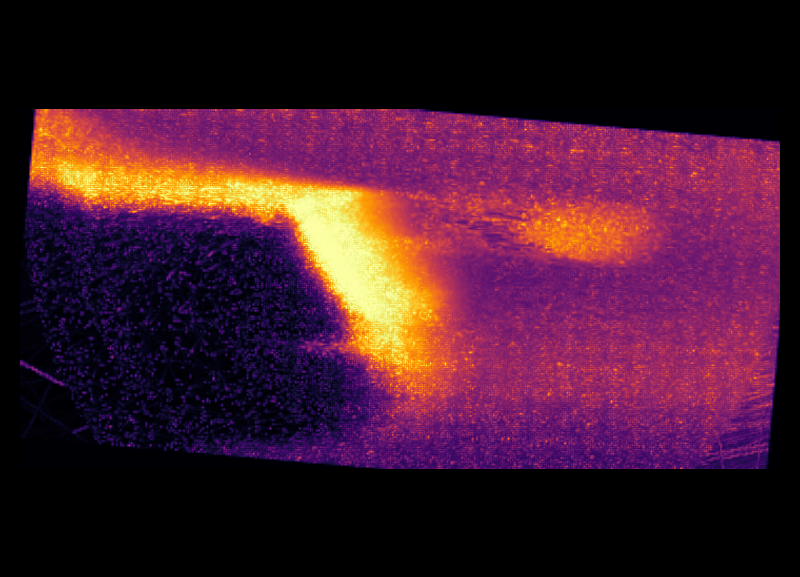

In [7]:
image_layer.visible = False
image_layer = viewer.add_image(rotated_image, colormap='inferno', scale=scale, blending='additive')

napari.utils.nbscreenshot(viewer, canvas_only=True)

### Slice extraction

Next, we need to extract the correct slice of the rotated 3D array. We can extract this information from the slice assignment file in conjunction with the info from the target_image.

In [8]:
for _name in glob.glob(os.path.join(target_image, '**/*00[0-9][0-9]_Scene*.czi'), recursive=True):
    name = np.array(os.path.split(_name)[-1].split('.')[0].split('_'))
    break

ind = np.argwhere(name == 'Scene')[0,0]
scene_query = '_'.join(name[ind - 1: ind + 2])
slice_query = slice_assignment[slice_assignment['File'] == scene_query]

In [9]:
# This is the entry we are looking for
slice_query

,Number,File,Depth,Assigned slice
8,9,0005_Scene_1,2000microns,59


In [10]:
slice_to_transform = rotated_image[:, slice_query['Assigned slice'], :]

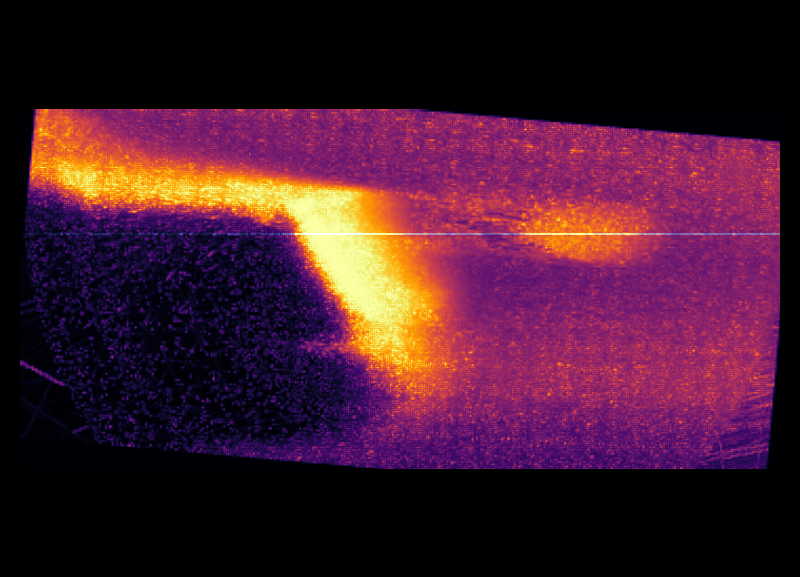

In [11]:
loc_world = slice_query['Assigned slice']*scale[0]
viewer.add_image(slice_to_transform, translate=[0, loc_world , 0], colormap='cyan', blending='additive', scale=scale)
napari.utils.nbscreenshot(viewer, canvas_only=True)

### Transformation with Transformix

Lastly, we need the correct transformation file to pply to the extracted image slice. This can be retrieved from the directory holding the transformation files (`trafo_dir`).

In [12]:
trafo_file = None
for file in os.listdir(trafo_dir):
    if scene_query in file and 'inverse' in file:
        trafo_file = os.path.join(trafo_dir, file)
        break
print(f'The correct transformmation file is {trafo_file}')

The correct transformmation file is E:\Promotion\Projects\2020_Slice2Volume\Data\P2A_C3H_M3\Histology\Warped\trafo\0005_Scene_1_trafo_inverse.txt


In [13]:
# Check that transformix.exe exists
if not 'transformix.exe' in os.listdir(elastix_dir):
    print(f'Transformix.exe not found in {elastix_dir}')
else:
    print(f'Found transformix at the specified location :)')

Found transformix at the specified location :)


We create a temporary directory at the location of this notebook to work with elastix. We then save the extracted image slice into this directory:

In [14]:
tmp_dir = os.path.join(os.getcwd(), 'tmp_dir')
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

moving_image = os.path.join(tmp_dir, f'{scene_query}_{os.path.basename(source_image)}')
io.imsave(moving_image, slice_to_transform.squeeze().astype(np.float32))

In [15]:
# Call transformix

command = ' '.join([os.path.join(elastix_dir, 'transformix.exe'),
                    '-in', moving_image,
                    '-tp',  trafo_file, 
                    '-out', tmp_dir])
subprocess.Popen(command)

<Popen: returncode: None args: 'E:\\Promotion\\Projects\\2020_Slice2Volume\\...>

# Overlay with target image

Last, we load the transformed image and overlay it with the target histology image. As target hitological image, we will use the image carrying the ID string specified above.

In [16]:
# We need to find this image in the target directory
ID = log['ID string'].loc[0]

for _name in glob.glob(os.path.join(target_image, f'**\\*{ID}*.tif'), recursive=True):
    name = _name
    
print(f'The target image is {name}')
print(f'The transformed image is {os.path.join(tmp_dir, "result.tif")}')

histo_image = io.imread(name)
transformed_image = io.imread(os.path.join(tmp_dir, 'result.tif'))

The target image is E:\Promotion\Projects\2020_Slice2Volume\Data\P2A_C3H_M3\Histology\Slices\0005_Scene_1\result\transformed_DAPI_r.tif
The transformed image is E:\Promotion\Projects\2020_Slice2Volume\Scripts\Codebase\Histology\Scripts\tmp_dir\result.tif


In [17]:
# Make a new viewer - we are in a different space now
viewer2 = napari.Viewer()

In [18]:
histo_image = transform.rotate(histo_image, angle = float(log['Initial rotation'].loc[0]), resize=True)
viewer2.add_image(histo_image, colormap='bop blue')

<Image layer 'histo_image' at 0x26e29a7fdc0>

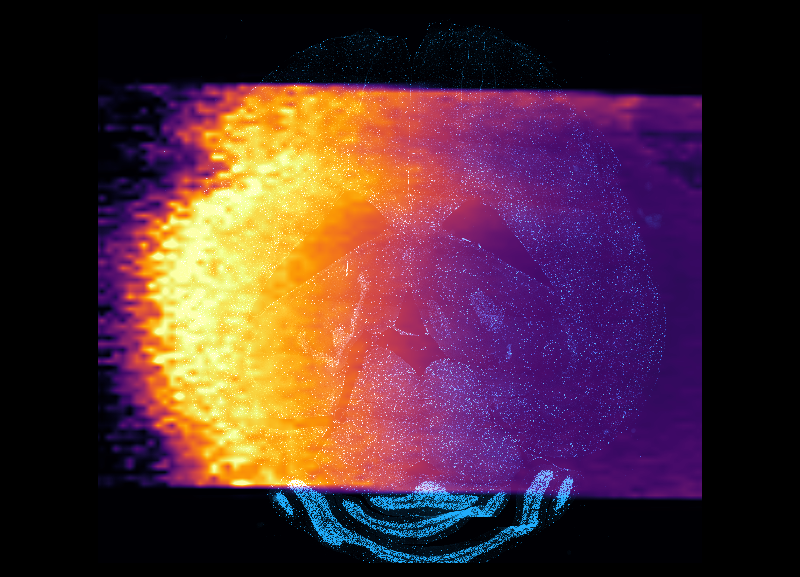

In [19]:
# Upsample transformed image and add to viewer
transformed_image = transform.resize(transformed_image, output_shape=histo_image.shape, preserve_range=True)
viewer2.add_image(transformed_image, colormap='inferno', blending='additive', contrast_limits=[0,1])
napari.utils.nbscreenshot(viewer2, canvas_only=True)

# Data export

... and a little cleanup. The transformed image will be saved in the above-specified `output_dir`.

In [20]:
# First, we remove the temporary directory from earlier:
shutil.rmtree(tmp_dir)

In [21]:
# Save the transformed data to a new directory:
io.imsave(os.path.join(output_dir, f'{scene_query}_{os.path.basename(source_image)}'), transformed_image)